توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [3]:
## download data
# %%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

--2023-12-23 14:36:08--  http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.131.233
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.csail.mit.edu/places/ADEchallenge/release_test.zip [following]
--2023-12-23 14:36:08--  https://data.csail.mit.edu/places/ADEchallenge/release_test.zip
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211820497 (202M) [application/zip]
Saving to: 'release_test.zip'

release_test.zip    100%[===================>] 202.01M  48.8MB/s    in 4.7s    

2023-12-23 14:36:13 (43.4 MB/s) - 'release_test.zip' saved [211820497/211820497]

--2023-12-23 14:36:14--  http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
Resolving data.csail.mit.edu (data.csail.mit.edu)...

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split
import torchvision.transforms.functional as F
from random import randint
import torch.nn.init as init


## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [5]:
# Function 1: Displacement
def displacement(img, shift_x, shift_y): # we get no. of x and y shift as the inputs
    height, width = img.shape[:2]
    T = np.float32([[1, 0, shift_x], [0, 1, shift_y]]) 
    img_translation = cv2.warpAffine(img, T, (width, height)) 
    return img_translation

# Function 2: Rotation
def rotation(img, angle):
    height, width = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height))
    return rotated_image

# Function 3: Scaling
def scaling(img, scale_factor):
    img_h, img_w = img.shape[0:2]
    
    cx = img_w//2
    cy = img_h//2
    
    tx = cx - scale_factor * cx
    ty = cy - scale_factor * cy
            
    # scale matrix
    sm = np.float32([[scale_factor, 0, tx],
                    [0, scale_factor, ty]])  # [1, 0, tx], [1, 0, ty]

    scaled_image = cv2.warpAffine(img, sm, (img_w, img_h))
    return scaled_image

# Function 4: Brightness
def brightness(img, factor):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
    bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bright_img

# Function 5: Blurring
def blurring(img, kernel_size):
    blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred_img

# Function 6: Gaussian Noise
def gaussian_noise(img, mean=0, sigma=25):
    row, col, ch = img.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_img = img + gauss
    noisy_img = np.clip(noisy_img, 0, 255)
    noisy_img = noisy_img.astype(np.uint8)
    return noisy_img

# Function 7: Cropping Image
def cropping(img):
    crop_size_percent=0.5
    # Get the dimensions of the image
    height, width = img.shape[:2]
    # Calculate the crop boundaries
    crop_top = int((height - height * crop_size_percent) / 2)
    crop_bottom = int(height - (height - height * crop_size_percent) / 2)
    crop_left = int((width - width * crop_size_percent) / 2)
    crop_right = int(width - (width - width * crop_size_percent) / 2)
    # Crop the image
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]
    return cropped_image

In [13]:
class CustomDataset(Dataset):

    def __init__(self,data_folder, first, second):
      self.data_folder = data_folder
      self.image_files = os.listdir(data_folder)[first:second]
      self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

    def change_image(self,image):
      changed_image = image.copy()
      label = 0
      transform_num = np.random.randint(0, 3) # how many changes do we need?
      if transform_num == 0:
        return changed_image, label
      else:
        transform_model = np.random.choice(['s','d','r'], size=transform_num, replace=False) # which transform do we use?
        if 'd' in transform_model:
          label += 1
          shift_x, shift_y = np.random.randint(-30,30), np.random.randint(-30,30)
#           shift_x, shift_y = 30 , 30
          changed_image = displacement(changed_image, shift_x, shift_y)
        if 's' in transform_model:
          label += 2
          scale_factor = np.random.uniform(1.1, 1.5) # as TA mentioned in class group, scaling with lower number than 1 doesnt have any difference with original image, so we didnt involve this factor.
#           scale_factor = 2
          changed_image = scaling(changed_image, scale_factor)
        if 'r' in transform_model:
          label += 4
          angle = np.random.randint(-45, 45)
#           angle = 45
          changed_image = rotation(changed_image, angle)

        return changed_image, label

    def __getitem__(self,idx):
      image_path = os.path.join(self.data_folder, self.image_files[idx])
      original_img = cv2.imread(image_path)
      original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
      modified_img, changed_label = self.change_image(original_img.copy())
      original_img = cropping(original_img)
      original_img = self.transform(original_img)  # apply the common transformations
      modified_img = cropping(modified_img)
      modified_img = self.transform(modified_img)   # apply the common transformations
      return original_img, modified_img, changed_label

    def __len__(self):
      return len(self.image_files)



In [14]:
# Specify the paths to your datasets
train_data_folder = "./ADEChallengeData2016/images/training"
test_data_folder = "./release_test/testing/"
val_data_folder = "./ADEChallengeData2016/images/validation"

# Create instances of CustomDataset for training, testing, and validation
dataset_train = CustomDataset(data_folder=train_data_folder,first = 1000, second = 16000)
dataset_val = CustomDataset(data_folder=val_data_folder,first = 0,second = 2000)
dataset_test = CustomDataset(data_folder=test_data_folder,first = 0, second = 2000)

# Set batch size for DataLoader
train_batch_size = 32
test_batch_size = 32
# Create DataLoader instances for training, testing, and validation
train_loader = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=train_batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=test_batch_size, shuffle=False)


# Plot dataset

These are trains, label =  (0, 1, 0) (displace, scaling, rotation)


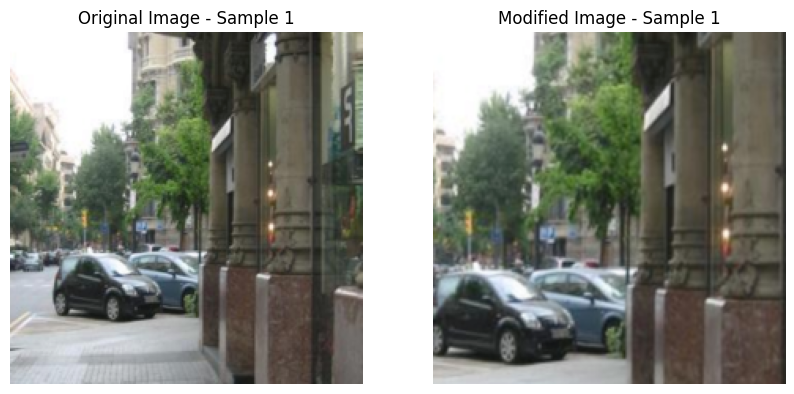

These are trains, label =  (1, 1, 0) (displace, scaling, rotation)


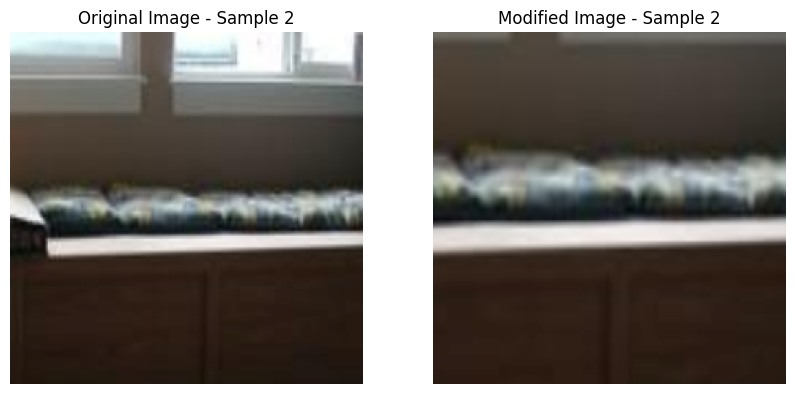

These are trains, label =  (0, 0, 0) (displace, scaling, rotation)


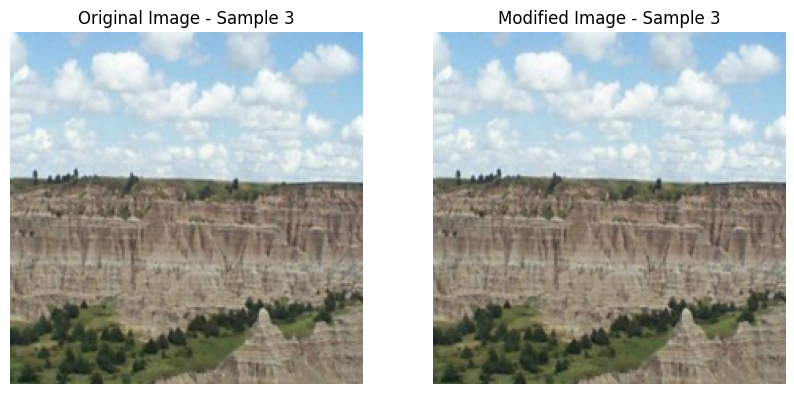

These are trains, label =  (0, 1, 0) (displace, scaling, rotation)


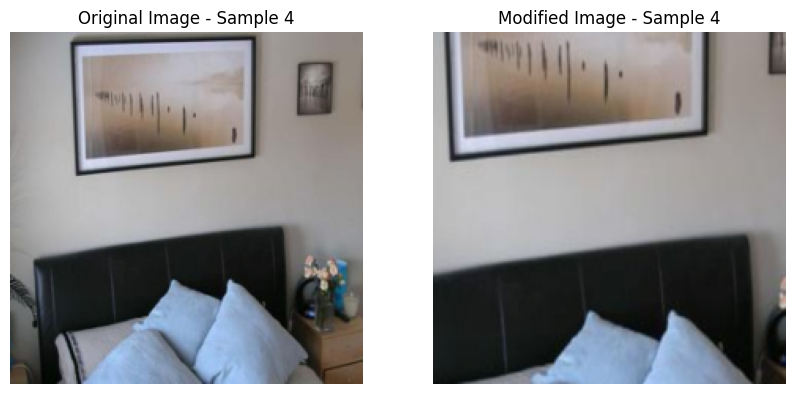

These are trains, label =  (1, 0, 0) (displace, scaling, rotation)


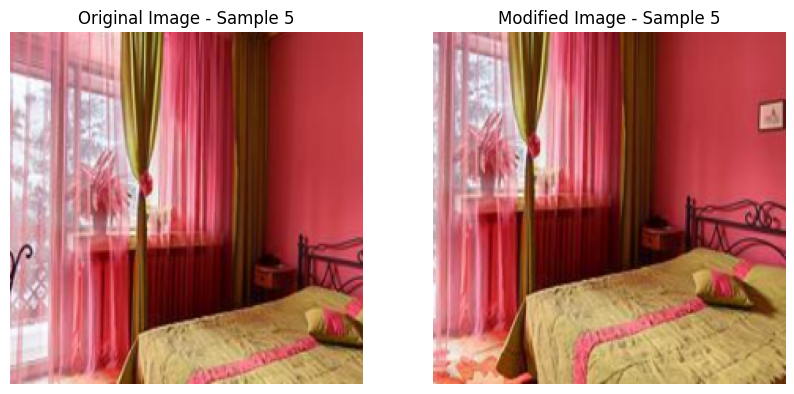

These are trains, label =  (1, 1, 0) (displace, scaling, rotation)


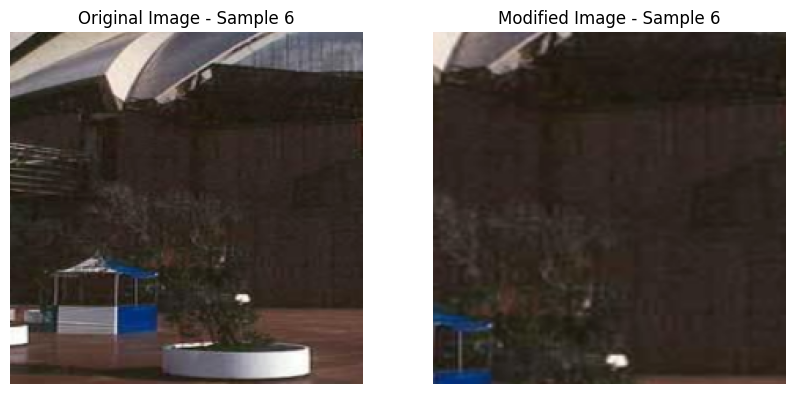

These are trains, label =  (1, 1, 0) (displace, scaling, rotation)


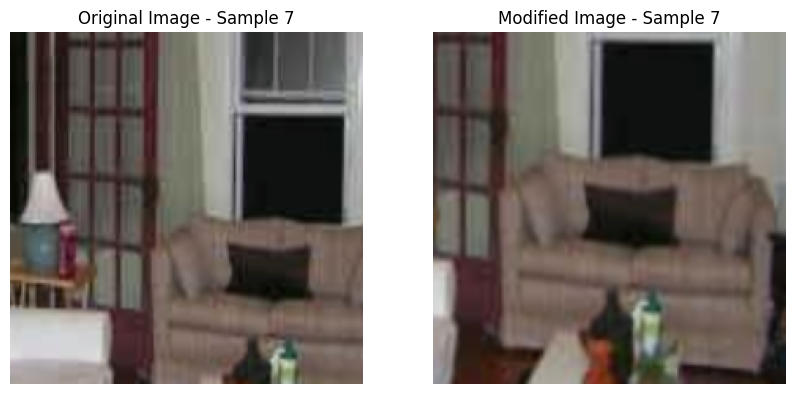

These are trains, label =  (0, 0, 0) (displace, scaling, rotation)


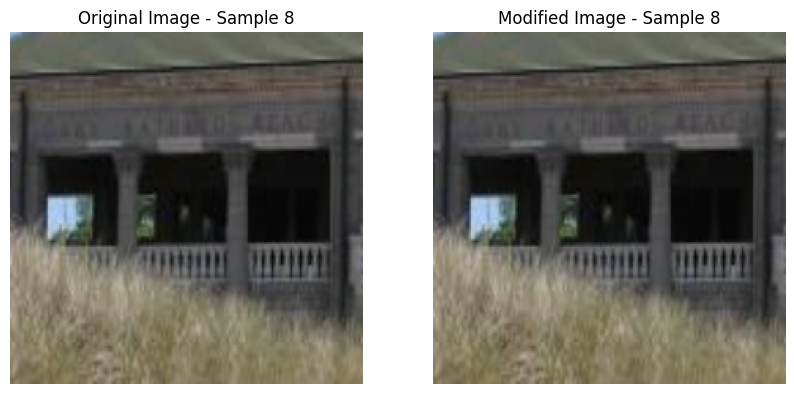

These are tests, label =  (0, 1, 0) (displace, scaling, rotation)


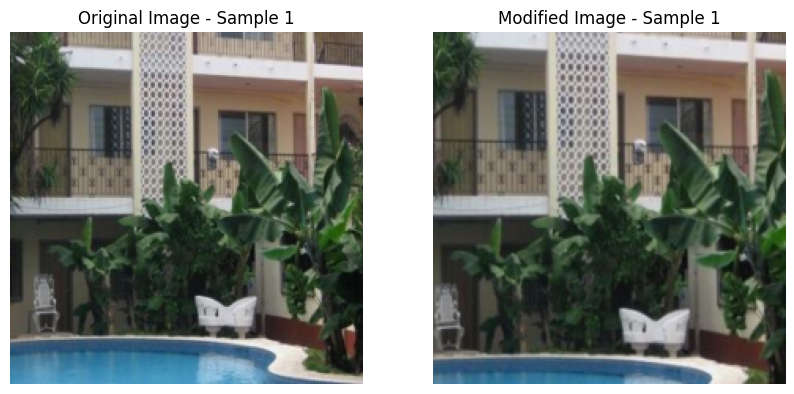

These are tests, label =  (0, 0, 0) (displace, scaling, rotation)


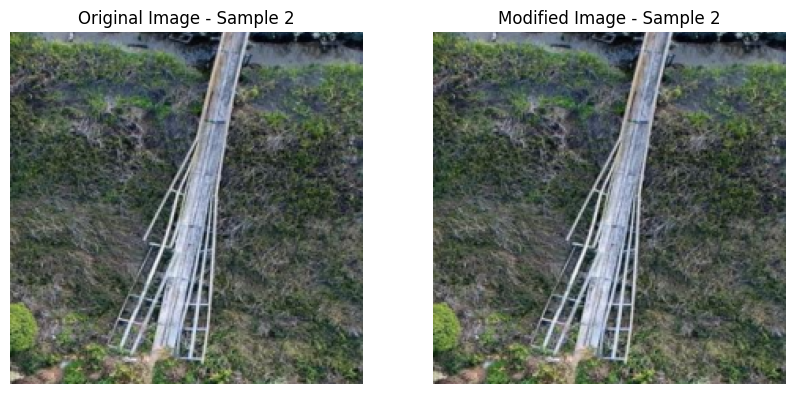

These are tests, label =  (0, 0, 0) (displace, scaling, rotation)


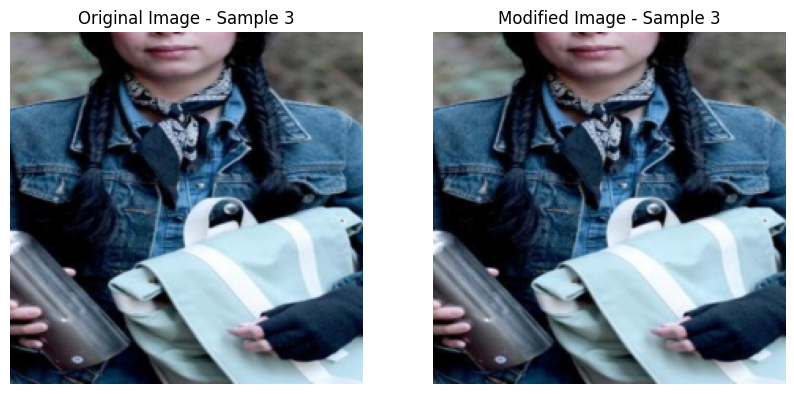

These are tests, label =  (0, 0, 1) (displace, scaling, rotation)


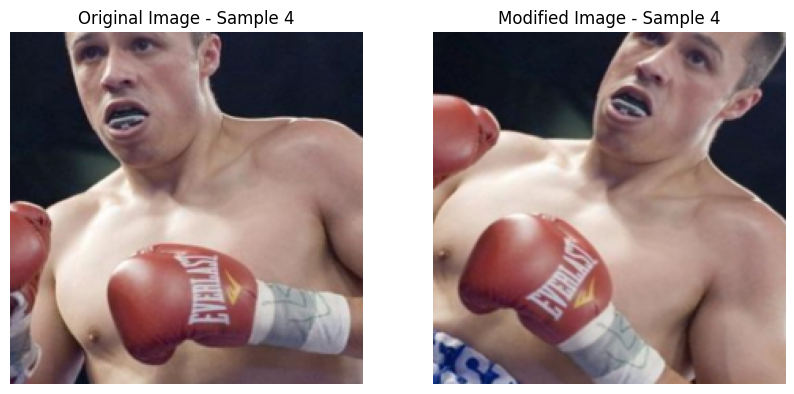

These are tests, label =  (1, 1, 0) (displace, scaling, rotation)


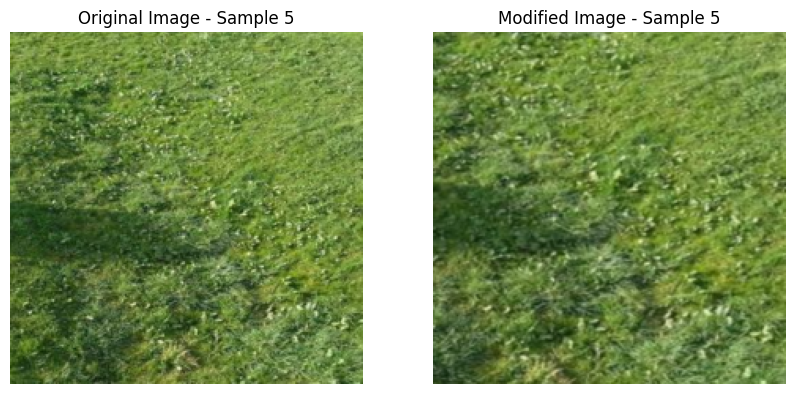

These are tests, label =  (1, 1, 0) (displace, scaling, rotation)


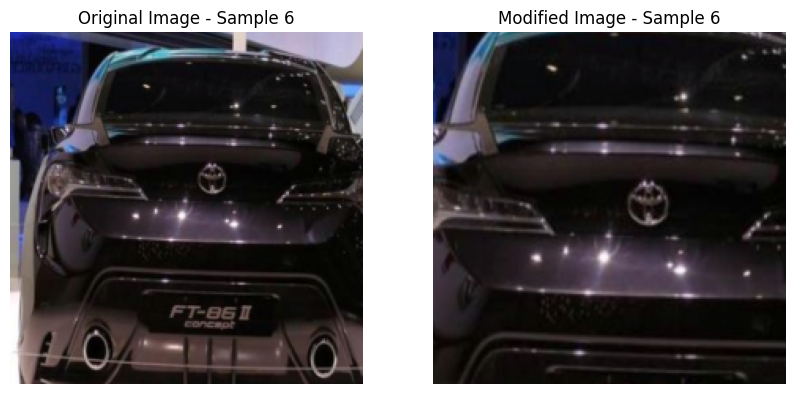

These are tests, label =  (0, 0, 0) (displace, scaling, rotation)


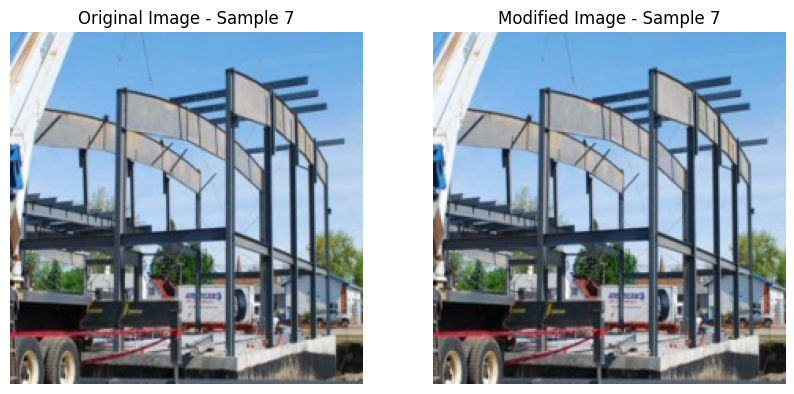

These are tests, label =  (0, 1, 1) (displace, scaling, rotation)


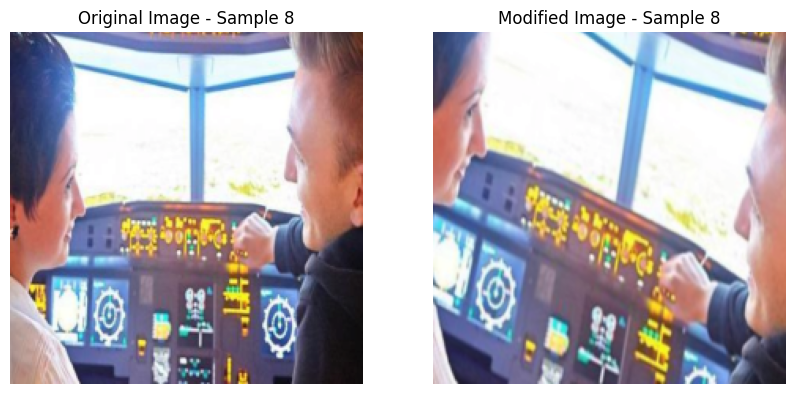

In [12]:
# Function to display images from a DataLoader
def show_images(loader, num_batches=1, num_images_per_batch=8, form =''):
    # Create an iterator from the DataLoader
    data_iter = iter(loader)
    
    for batch_num in range(num_batches):
        # Extract the images and labels from the batch
        original_images, modified_images, labels = next(data_iter)
        # Unnormalize the images (assuming they were normalized during transformation)
        inv_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
                                            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
                                            transforms.ToPILImage()])
        unnorm_original_images = [np.array(inv_transform(img)).transpose(2, 0, 1) for img in original_images]
        unnorm_modified_images = [np.array(inv_transform(img)).transpose(2, 0, 1) for img in modified_images]
        
        # Plot the images for the current batch
        for i in range(num_images_per_batch):
            x = bin(labels[i].item())[2:].zfill(3)
            target = [int(bit) for bit in x]
            # Convert images back to (H, W, C) format for display
            original_img_display = np.transpose(unnorm_original_images[i], (1, 2, 0))
            modified_img_display = np.transpose(unnorm_modified_images[i], (1, 2, 0))

            # Create a new figure for each pair of modified and original images
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(original_img_display)
            plt.title(f"Original Image - Sample {i + 1}")
            plt.axis('off')
            print(f"These are {form}, label =  {target[2],target[1],target[0]} (displace, scaling, rotation)")
            plt.subplot(1, 2, 2)
            plt.imshow(modified_img_display)
            plt.title(f"Modified Image - Sample {i + 1}")
            plt.axis('off')

            plt.show()

# Display images from the first batch in the training loader
show_images(train_loader, num_batches=1, num_images_per_batch=8, form='trains')
show_images(test_loader, num_batches=1, num_images_per_batch=8, form='tests')


In [20]:
import os

# List the contents of the extracted directory
extracted_folder_contents = os.listdir('./ADEChallengeData2016')

# Print the contents to understand the structure
print(extracted_folder_contents)

['annotations', 'sceneCategories.txt', 'images', 'objectInfo150.txt']


# Creating Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

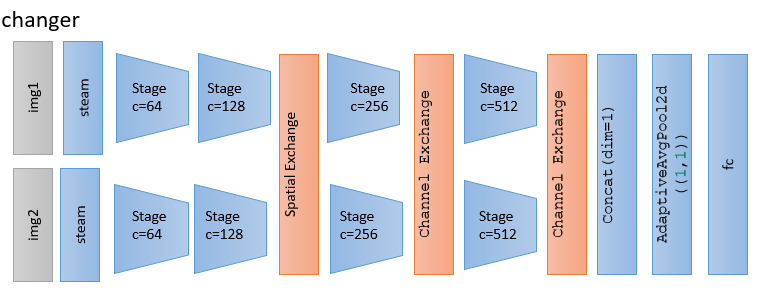

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


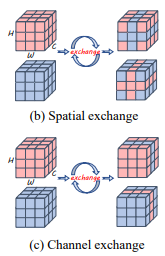

In [15]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

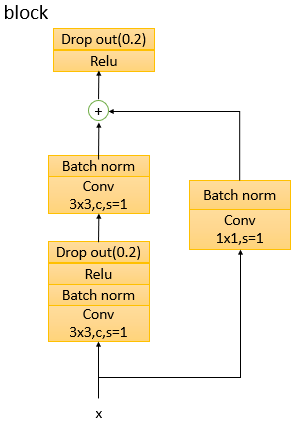

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





**پاسخ سوال تئوری 1:**


1.
تعداد پدینگ برای کرنل‌های 3در3 برابر با 1 است و برای کرنل 1در1 برابر با صفر.
تعداد چنل خروجی نیز با توجه به تصویر بعدی برابر 64 در نظر گرفتیم.


2. دلیل استفاده کانوولشن 1*1 این است که با به کمک این فیلتر میتوانیم روابط بین کانال‌های تصویر را بدست آوریم. همانطور که مستحضرید در فیلتر 1 در 1 ما تمامی کانال‌ها را به یکی تبدیل میکنیم و این عمل سبب میشود که به عبارتی اطلاعات تمامی کانال و رابطه‌ بین آنها در یک بعد بدست بیاید. طبیعتا با این عمل حجم داده نیز کاهش می‌یابد و این باعث نیاز کمتر به مموری و محاسبه است.


In [16]:
##To Do
class block(nn.Module):
  def __init__(self,in_channels ,out_channels):
    super(block,self).__init__()
    # Pathway 1: 1x1 Convolution Layer with Batch Normalization
    self.pathway1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(out_channels)
    )

    # Pathway 2: 3x3 Convolution Layers with Batch Normalization, ReLU, and Dropout
    self.pathway2 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features =   out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.2),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features = out_channels)
    )

    # Final ReLU and Dropout
    self.final_relu = nn.ReLU(inplace=True)
    self.final_dropout = nn.Dropout2d(p=0.2)


  def forward(self,x):

    # Pathway 1
    out1 = self.pathway1(x)

    # Pathway 2
    out2 = self.pathway2(x)

    # Element-wise addition
    out = out1 + out2

    # Final ReLU and Dropout
    out = self.final_relu(out)
    out = self.final_dropout(out)

    return out

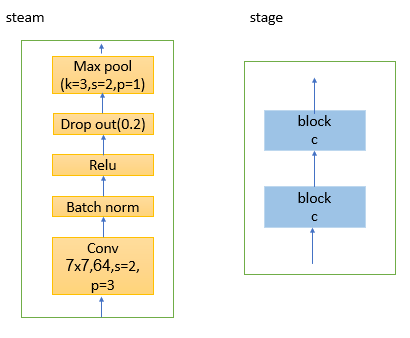

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [17]:
#To Do
class changer(nn.Module):
  def __init__(self, input_changer_size = 3):
    super(changer,self).__init__()

    self.steam=nn.Sequential(nn.Conv2d(in_channels = input_changer_size, out_channels=32, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(num_features = 32),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1 )
        )

    self.stage1 = self._make_stage(block, stage_input = 32 , stage_output = 64)
    self.stage2 = self._make_stage(block, stage_input = 64 , stage_output = 128)
    self.stage3 = self._make_stage(block, stage_input = 128 , stage_output = 256)
    self.stage4 = self._make_stage(block, stage_input = 256 , stage_output = 512)

    self.spatial_exchange1 = SpatialExchange()
    self.channel_exchange1 = ChannelExchange()
    self.channel_exchange2 = ChannelExchange()
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    # Fully Connected Layers
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(512, 7),
        nn.Softmax()
    )
  def _make_stage(self,block,stage_input,stage_output):

    layers = [
            block(in_channels = stage_input ,  out_channels = stage_output),
            block(in_channels = stage_output , out_channels = stage_output)
        ]

    return nn.Sequential(*layers)


  def forward(self,x1,x2):
    x1 = self.steam(x1)
    x1 = self.stage1(x1)
    x1 = self.stage2(x1)
    x2 = self.steam(x2)
    x2 = self.stage1(x2)
    x2 = self.stage2(x2)
    x1, x2 = self.spatial_exchange1(x1, x2)
    x1 = self.stage3(x1)
    x2 = self.stage3(x2)
    x1, x2 = self.channel_exchange1(x1, x2)
    x1 = self.stage4(x1)
    x2 = self.stage4(x2)
    x1, x2 = self.channel_exchange2(x1, x2)
    x = torch.cat([x1, x2], dim=1)
    x = self.avg_pool(x)
    out = self.fc(x)
    return out

In [18]:
## To Do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model=changer().to(device)

criterion = nn.CrossEntropyLoss()## loss
optimizer= optim.Adam(model.parameters(), lr=0.0001)## optimizer


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.xavier_uniform_(m.weight)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0)

# Apply Xavier initialization to the weights and biases
initialize_weights(model)

cuda


In [19]:
import gc
torch.cuda.empty_cache()
gc.collect()

2937

# Train & validation

In [20]:
# Load the best model (if you haven't already loaded it)
file_name = '/kaggle/input/noname1/best_model (1).pth' 
model = changer().to(device)
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [21]:
best_model_path = 'best_model.pth'
# Training and validation loops
Loss_train = []
Loss_val = []
best_val_accuracy = 0.0  # Variable to store the best validation accuracy

num_epochs = 20

def change_label_form(input_label):
  # numpy_array = np.array([tensor.numpy() for tensor in input_label]).T
  outp = torch.stack(tuple(input_label)).T
  # outp = outp.to(torch.long)
  # outp = outp.argmax(dim=1).long()
  outp = outp.to(device)
  return outp

# Training loop
for epoch in range(num_epochs):  # Replace num_epochs with the desired number of epochs
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (image1_train, image2_train, labels_train) in enumerate(train_loader):
        image1_train = image1_train.to(device)
        image2_train = image2_train.to(device)
        labels_train = labels_train.to(device)
        # labels = change_label_form(labels_train)

        optimizer.zero_grad()
        outputs = model(image1_train, image2_train)  # Assuming the model takes two identical inputs (for example, an image and its augmented version)
        # print(outputs)
        # outputs = change_label_form(outputs)
        loss = criterion(outputs, labels_train)
        loss.backward()
        optimizer.step()

        train_loss  += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train  += (predicted == labels_train).sum().item()
        total_train += labels_train.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i,(image1_val, image2_val, labels_val) in enumerate(val_loader):
            image1_val = image1_val.to(device)
            image2_val = image2_val.to(device)
            labels_val = labels_val.to(device)
            # labels_val = change_label_form(labels_val)
            outputs = model(image1_val, image2_val)
            loss = criterion(outputs, labels_val)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val  += (predicted == labels_val).sum().item()
            total_val += labels_val.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    Loss_train.append(avg_train_loss)
    Loss_val.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Avg. Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, '
          f'Avg. Val Loss: {avg_val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}')

    # Save the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, best_model_path)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/20, Avg. Train Loss: 1.547, Train Accuracy: 0.599, Avg. Val Loss: 1.521, Val Accuracy: 0.629
Epoch 2/20, Avg. Train Loss: 1.548, Train Accuracy: 0.598, Avg. Val Loss: 1.539, Val Accuracy: 0.613
Epoch 3/20, Avg. Train Loss: 1.543, Train Accuracy: 0.607, Avg. Val Loss: 1.525, Val Accuracy: 0.625
Epoch 4/20, Avg. Train Loss: 1.544, Train Accuracy: 0.605, Avg. Val Loss: 1.520, Val Accuracy: 0.638
Epoch 5/20, Avg. Train Loss: 1.538, Train Accuracy: 0.611, Avg. Val Loss: 1.511, Val Accuracy: 0.640
Epoch 6/20, Avg. Train Loss: 1.550, Train Accuracy: 0.598, Avg. Val Loss: 1.522, Val Accuracy: 0.625
Epoch 7/20, Avg. Train Loss: 1.549, Train Accuracy: 0.598, Avg. Val Loss: 1.519, Val Accuracy: 0.627
Epoch 8/20, Avg. Train Loss: 1.547, Train Accuracy: 0.602, Avg. Val Loss: 1.504, Val Accuracy: 0.650
Epoch 9/20, Avg. Train Loss: 1.553, Train Accuracy: 0.592, Avg. Val Loss: 1.531, Val Accuracy: 0.619
Epoch 10/20, Avg. Train Loss: 1.544, Train Accuracy: 0.606, Avg. Val Loss: 1.526, Val Accur

KeyboardInterrupt: 

**در اینجا ما 15 ایپاک از ایپاکهای میانی را رسم کردیم. همانطور که مستحضرید اجرا شدن تمامی ایپاکها به صورت همزمان، بسیار وقت گیر است، لذا ما بخشی از آن را نمایش دادیم.**

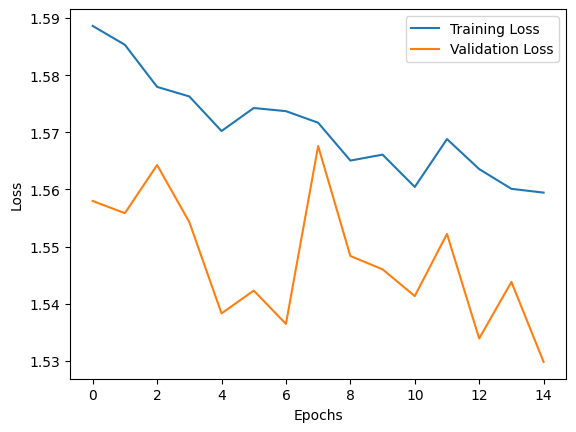

In [15]:

plt.plot(range(15), Loss_train, label='Training Loss')
plt.plot(range(15), Loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Final Test Results: Avg. Test Loss: 1.501, Test Accuracy: 0.647


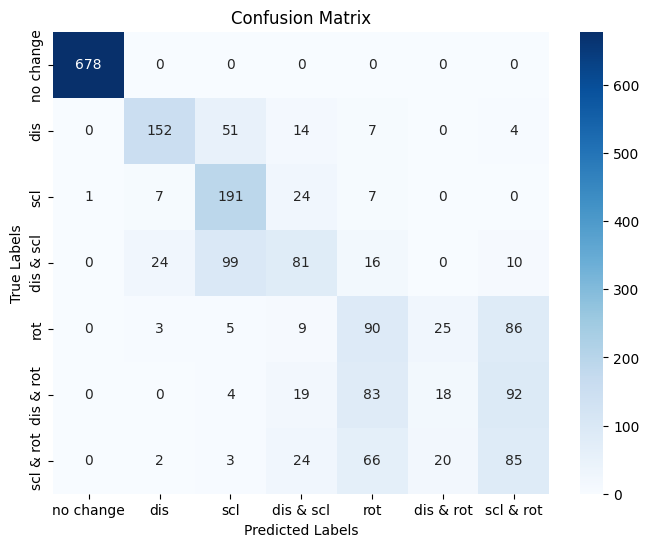

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_model = changer().to(device)
checkpoint = torch.load(best_model_path)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

# Test loop
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for i, (image1_test, image2_test, labels_test) in enumerate(test_loader):
        image1_test = image1_test.to(device)
        image2_test = image2_test.to(device)
        labels_test = labels_test.to(device)
        # labels_test = change_label_form(labels_test)
        outputs = best_model(image1_test, image2_test)
        loss = criterion(outputs, labels_test)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels_test).sum().item()
        total_test += labels_test.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels_test.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Final Test Results: '
      f'Avg. Test Loss: {avg_test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
class_names = ['no change', 'dis', 'scl', 'dis & scl', 'rot', 'dis & rot', 'scl & rot']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

با توجه به 
confusion matrix
برسم شده میبینیم که هرچه تعداد تغییرات کمتر باشد، مدل بهتر عمل می‌کند. همچنین تصاویری که چرخش و جابجایی داشته‌اند بدتر شناسایی می‌شوند. علت این امر این است که در چرخش با توجه به اینکه ما هم چرخش منفی و هم مثبت داریم، گاهی اوقات این چرخش بسیار نزدیک به تصویر اصلی بوده و نمی‌توان آن را به خوبی تشخیص داد. در مورد جابجایی نیز دقیقا همین نکته قابل ذکر است.
مثلا اگر به قسمت 
dis & scl 
توجه کنید، میبینید که بسیاری از آنها صرفا تغییر مقیاس تلقی شده، زیرا جابجایی ما بسیار کم بوده است.